<a href="https://colab.research.google.com/github/Xuwei-Tang/graduation-project/blob/main/DensityVisDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/VisDrone2020-CC.zip" -d "/content/drive/MyDrive/"

In [ ]:
#set the root to the Shanghai dataset you download
root = '/content/'

In [ ]:
import os
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

In [ ]:
print(path_sets)

['/content/train/sequences', '/content/test/sequences']


les deux datasets

In [ ]:
img_folder_paths = []
for path in path_sets:
  for path, dirs, files in os.walk(path):
    for d in dirs:
      img_folder_paths.append(d)
    break
print(len(img_folder_paths))

112


train dataset

In [ ]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(len(img_folder_paths))

82


In [ ]:
import matplotlib.pyplot as plt

In [52]:
for img_folder_path in img_folder_paths:
    print (img_folder_path)

/content/VisDrone2020-CC/train/sequences/00008
/content/VisDrone2020-CC/train/sequences/00110
/content/VisDrone2020-CC/train/sequences/00030
/content/VisDrone2020-CC/train/sequences/00053
/content/VisDrone2020-CC/train/sequences/00014
/content/VisDrone2020-CC/train/sequences/00026
/content/VisDrone2020-CC/train/sequences/00013
/content/VisDrone2020-CC/train/sequences/00104
/content/VisDrone2020-CC/train/sequences/00076
/content/VisDrone2020-CC/train/sequences/00047
/content/VisDrone2020-CC/train/sequences/00041
/content/VisDrone2020-CC/train/sequences/00054
/content/VisDrone2020-CC/train/sequences/00049
/content/VisDrone2020-CC/train/sequences/00079
/content/VisDrone2020-CC/train/sequences/00092
/content/VisDrone2020-CC/train/sequences/00106
/content/VisDrone2020-CC/train/sequences/00020
/content/VisDrone2020-CC/train/sequences/00087
/content/VisDrone2020-CC/train/sequences/00086
/content/VisDrone2020-CC/train/sequences/00037
/content/VisDrone2020-CC/train/sequences/00050
/content/VisD

In [ ]:
from google.colab.patches import cv2_imshow

/content/train/sequences/00055
00012.jpg
/content/train/annotations/00055.txt


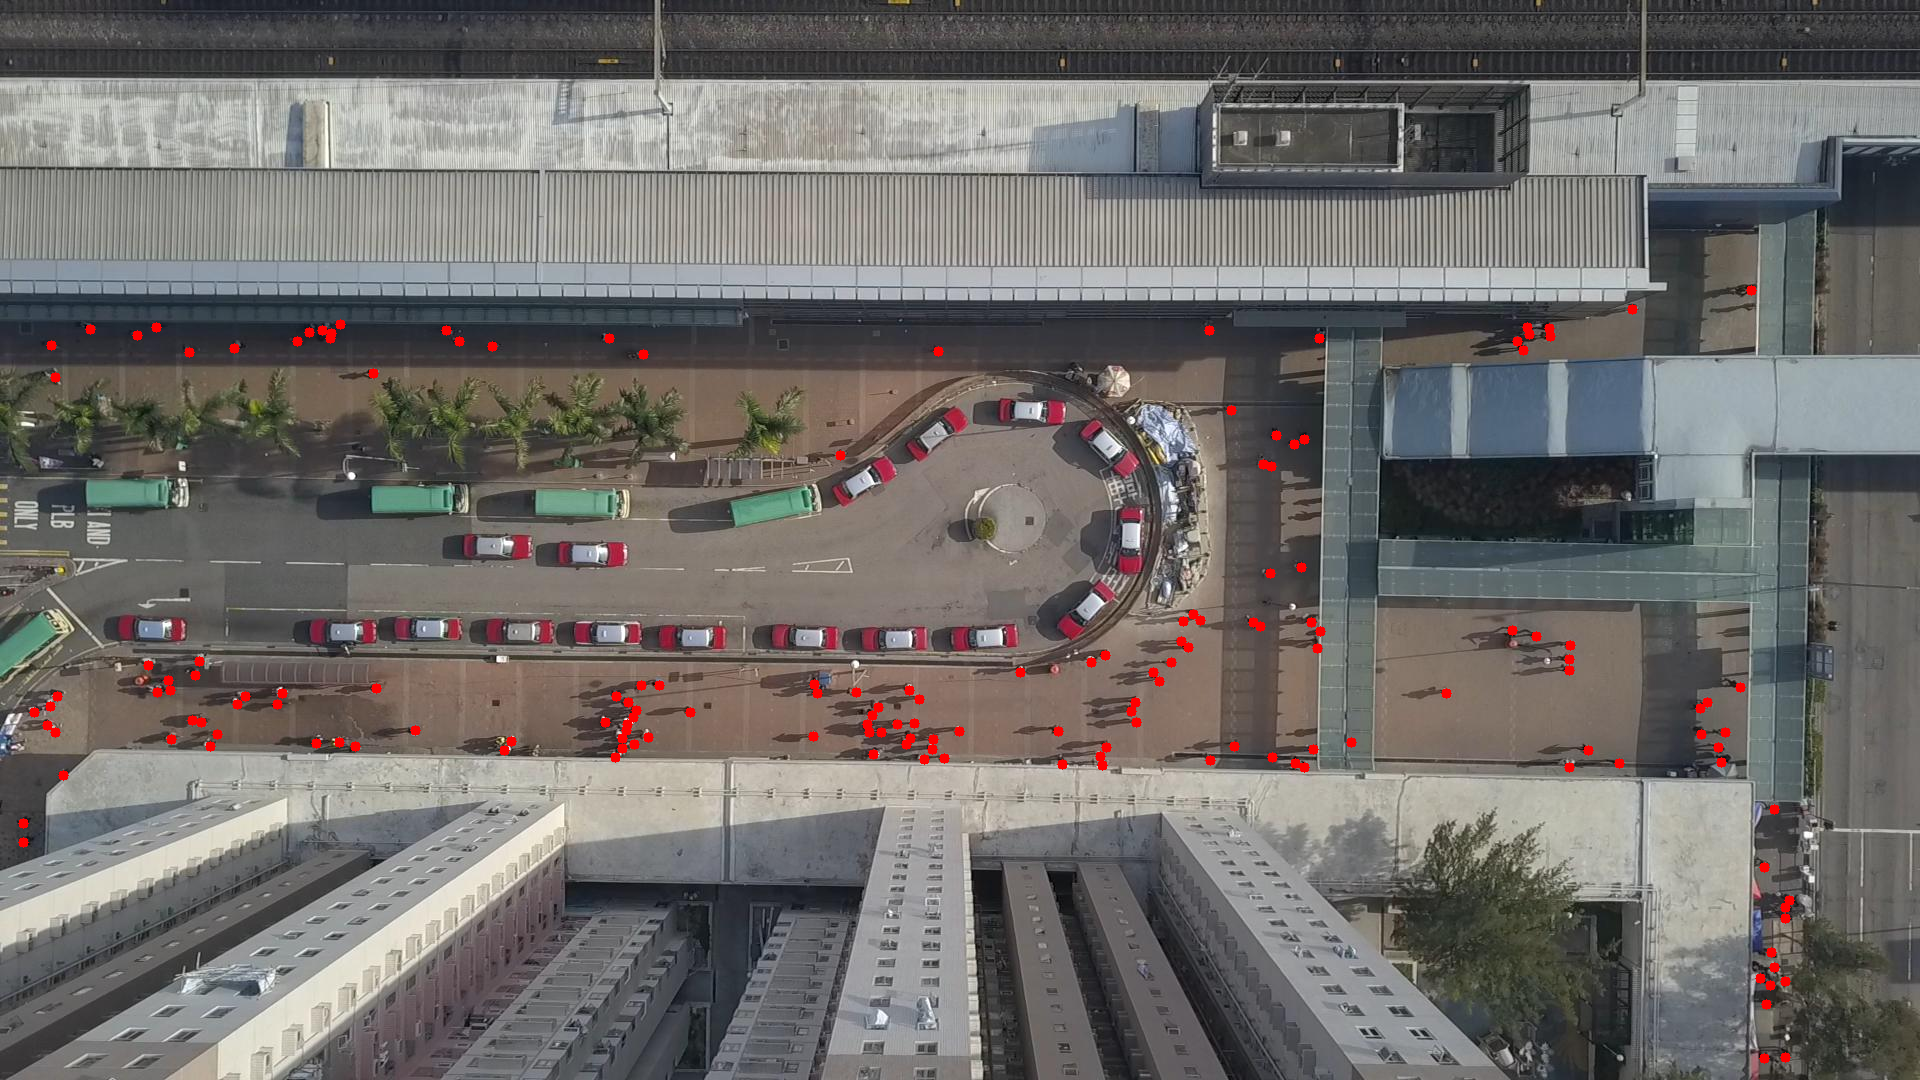

In [ ]:
import cv2
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      img= cv2.imread(img_folder_path+"/"+img_path)
      print(img_path)
      annotation = img_path.replace('.jpg','')
      pos = 0
      for nbr in annotation:
        if nbr != '0':
          #print(nbr)
          annotation = annotation[pos:]
          break
        pos+=1
      #print(annotation)
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      #plt.imshow(img)
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        #print(ligne.strip())
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        #print(line)
        if line[0] == int(annotation):
          #print(line[0], int(annotation))
          #plt.scatter([line[1]], line[2])
          img = cv2.circle(img,(line[1],line[2]), 5, (0,0,255), -1)


      break
  break
cv2_imshow(img)

**Awesome CC density map generation**

In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
#from model import CSRNet
import torch
%matplotlib inline

In [ ]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    print(pts)
    leafsize = 2048
    # build kdtree
    tree = spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
import time

In [ ]:
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      #img= cv2.imread(img_folder_path+"/"+img_path)
      img = plt.imread(img_folder_path+"/"+img_path)
      print(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      annotation = img_path.replace('.jpg','')
      pos = 0
      #nombre de l'image
      for nbr in annotation:
        if nbr != '0':
          annotation = annotation[pos:]
          break
        pos+=1
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          k[line[2], line[1]] = 1
      #print(k)
      start_time = time.time()
      k = gaussian_filter_density(k)
      print("Temps d execution : %s secondes ---" % (time.time() - start_time))
      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k
      break
  break

/content/train/sequences/00055
00012.jpg
/content/train/annotations/00055.txt
(1080, 1920)
[[1751  290]
 [1632  309]
 [ 340  324]
 [ 156  327]
 [1527  327]
 [1549  328]
 [  90  329]
 [ 322  330]
 [ 446  330]
 [1209  330]
 [ 309  332]
 [ 331  333]
 [1529  334]
 [ 137  335]
 [1550  336]
 [ 330  338]
 [ 609  338]
 [1319  338]
 [ 297  341]
 [ 459  341]
 [1517  341]
 [  51  345]
 [ 492  346]
 [ 234  348]
 [1523  350]
 [ 938  351]
 [ 189  352]
 [ 643  354]
 [ 373  373]
 [  55  377]
 [1231  410]
 [1276  435]
 [1304  439]
 [1294  444]
 [ 840  455]
 [1263  464]
 [1271  466]
 [1301  567]
 [1270  573]
 [1193  614]
 [1200  620]
 [1183  621]
 [1253  622]
 [1311  622]
 [1260  626]
 [1512  630]
 [1320  631]
 [1536  636]
 [1181  641]
 [1570  645]
 [1188  647]
 [1317  648]
 [1105  655]
 [1569  659]
 [ 199  661]
 [1091  662]
 [1171  662]
 [ 148  665]
 [1569  670]
 [1020  672]
 [1153  672]
 [ 195  675]
 [ 168  680]
 [1159  681]
 [ 814  684]
 [ 641  685]
 [ 659  685]
 [1740  687]
 [ 376  688]
 [ 170  690]

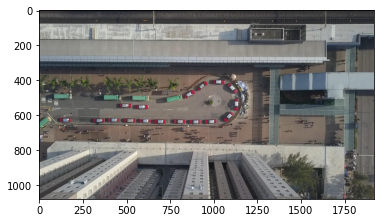

In [ ]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_folder_path+"/"+files[0]))

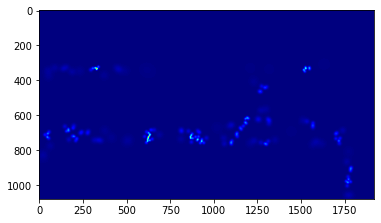

In [ ]:
gt_file = h5py.File(files[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)# don't mind this slight variation

164.62938

In [ ]:
#now generate the ShanghaiA's ground truth
train = os.path.join(root,'train/sequences')
test = os.path.join(root,'test/sequences')
path_sets = [train,test]

In [ ]:
img_folder_paths=[]
for path, dirs, files in os.walk(path_sets[0]):
    for d in dirs:
      img_folder_paths.append(path_sets[0]+"/"+d)
print(len(img_folder_paths))

82


In [ ]:
for img_folder_path in img_folder_paths:
  print(img_folder_path)
  for path, dirs, files in os.walk(img_folder_path):
    for img_path in files:
      #img= cv2.imread(img_folder_path+"/"+img_path)
      img = plt.imread(img_folder_path+"/"+img_path)
      print(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      annotation = img_path.replace('.jpg','')
      pos = 0
      #nombre de l'image
      for nbr in annotation:
        if nbr != '0':
          annotation = annotation[pos:]
          break
        pos+=1
      file_annota = open(img_folder_path.replace('sequences','annotations')+".txt", "r")
      print(img_folder_path.replace('sequences','annotations')+".txt")
      lines = file_annota.readlines()
      file_annota.close()
      for ligne in lines:
        line = ligne.strip()
        line = line.split(",")
        line = list(map(int, line))
        if line[0] == int(annotation):
          k[line[2], line[1]] = 1
      print(k)
      start_time = time.time()
      k = gaussian_filter(k,15)
      print("Temps d execution : %s secondes ---" % (time.time() - start_time))
      with h5py.File(img_path.replace('.jpg','.h5').replace('00012','000122'), 'w') as hf:
            hf['density'] = k
      break
  break

/content/train/sequences/00055
00012.jpg
/content/train/annotations/00055.txt
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Temps d execution : 0.33669400215148926 secondes ---


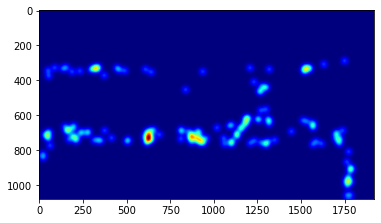

In [ ]:
gt_file = h5py.File(files[0].replace('.jpg','.h5').replace('00012','000122'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)

164.99999999999991